In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from hagelslag.evaluation import DistributedROC, DistributedReliability
from scipy.stats import gamma

In [2]:
members = ["wrf-s3cn_arw"] + ["wrf-s3m{0:d}_arw".format(x) for x in range(3, 14)]
combo_data = {}
for member in members:
    combo_data[member] = pd.read_csv("/Users/djgagne/track_forecasts_spring2015_cqg_masked_merged_csv/track_forecast_data_SSEF_{0}_combined.csv".format(member))

In [4]:
member_info = pd.read_csv("member_info_ssef_spring2015.csv", index_col="Ensemble_Member")
print member_info

                                  IC                BC Microphysics   LSM  \
Ensemble_Member                                                             
wrf-s3cn_arw               00Z ARPSa          00Z NAMf     Thompson  Noah   
wrf-s3m3_arw       arw_cn+em-p1_pert    21Z SREF em-p1           MY  Noah   
wrf-s3m4_arw       arw_cn+em-n2_pert    21Z SREF em-n2           MY  Noah   
wrf-s3m5_arw      arw_cn+nmm-p1_pert   21Z SREF nmm-p1     Morrison  Noah   
wrf-s3m6_arw     arw_cn+nmmb-n1_pert  21Z SREF nmmb-n1           MY  Noah   
wrf-s3m7_arw     arw_cn-nmmb_p1_pert  21Z SREF nmmb-p1           MY  Noah   
wrf-s3m8_arw       arw_cn-em-n1_pert    21Z SREF em-n1           MY  Noah   
wrf-s3m9_arw       arw_cn-em-p2_pert    21Z SREF em-p2           MY  Noah   
wrf-s3m10_arw    arw_cn-nmmb-n3_pert  21Z SREF nmmb-n3     Morrison  Noah   
wrf-s3m11_arw    arw_cn-nmmb-p3_pert  21Z SREF nmmb-p3     Thompson  Noah   
wrf-s3m12_arw      arw_cn-em-p3_pert    21Z SREF em-p3     Thompson  Noah   

In [4]:
def mean_absolute_error(forecast, obs):
    return np.mean(np.abs(forecast - obs))

for member in members:
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    print member, 
    print mean_absolute_error(matched_data["Random-Forest-CV_Scale"], matched_data["Scale"]),
    print mean_absolute_error(matched_data["Random-Forest_Scale"], matched_data["Scale"])

wrf-s3cn_arw 2.5650785101 2.56015182728
wrf-s3m3_arw 2.62813236067 2.63886401237
wrf-s3m4_arw 2.72047294323 2.74290285231
wrf-s3m5_arw 2.81615204156 2.83354724442
wrf-s3m6_arw 2.80358798572 2.81365666829
wrf-s3m7_arw 2.63123091365 2.64743510495
wrf-s3m8_arw 2.77260986466 2.77731908498
wrf-s3m9_arw 2.81081955815 2.83582389495
wrf-s3m10_arw 2.6969050455 2.71815483409
wrf-s3m11_arw 2.68944822356 2.7076121097
wrf-s3m12_arw 2.63850496541 2.65099399964
wrf-s3m13_arw 2.55876435273 2.57916806211


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    4.,   12.,   11.,
          25.,   25.,   70.,   96.,  148.,   94.,  196.,  148.,  234.,
         299.,  224.,  406.,  296.,  268.,  272.,  222.,  178.,  110.,
          83.,   44.,   52.,   14.,    2.,    3.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ -2.00000000e+00,  -1.90000000e+00,  -1.80000000e+00,
         -1.70000000e+00,  -1.60000000e+00,  -1.50000000e+00,
         -1.40000000e+00,  -1.30000000e+00,  -1.20000000e+00,
         -1.10000000e+00,  -1.00000000e+00,  -9.00000000e-01,
         -8.00000000e-01,  -7.00000000e-01,  -6.00000000e-01,
         -5.00000000e-01,  -4.00000000e-01,  -3.00000000e-01,
         -2.00000000e-01,  -1.00000000e-01,   1.77635684e-15,
          1.00000000e-01,   2.00000000e-01,   3.00000000e-01,
          4.00000000e-01,   5.000

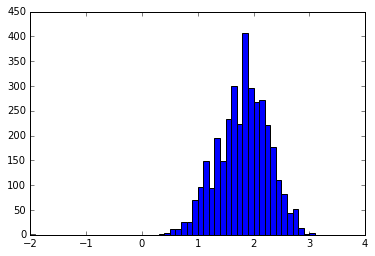

In [33]:
predictand = "Scale"
member = "wrf-s3cn_arw"
tidx = combo_data[member]["Hail_Size"] > 0
plt.hist(np.log(combo_data[member].loc[tidx, [predictand]].values), bins=np.arange(-2, 4, 0.1))
#plt.hist(combo_data[member].loc[tidx, ["Elastic-Net_" + predictand]].values, bins=np.arange(0, 20, 0.5))

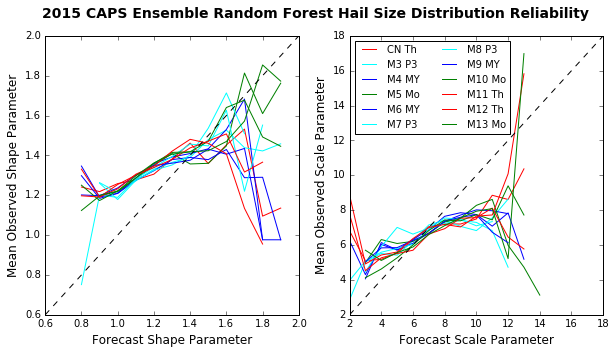

In [6]:
def mean_absolute_error(forecast, obs):
    return np.mean(np.abs(forecast - obs))

scale_bins = np.arange(1, 20, 1)
shape_bins = np.arange(0.5, 4, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Random-Forest-CV_Scale"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Scale"] < scale_bins[b+1]), "Scale"].mean()
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Random-Forest-CV_Shape"] >= sbin) & 
                                             (matched_data["Random-Forest-CV_Shape"] < shape_bins[b+1]), "Shape"].mean()
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "MicrophysicsTrue"][:3], color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper() + " " + member_info.loc[member, "MicrophysicsTrue"][:2],
            color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]])
ax2.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(np.arange(0.6, 2.1, 0.1), np.arange(0.6,2.1,0.1), 'k--')
ax2.plot(np.arange(2, 19), np.arange(2, 19), 'k--')
ax1.set_xlim(0.6, 2)
ax1.set_ylim(0.6, 2)
ax1.set_xlabel("Forecast Shape Parameter", fontsize=12)
ax1.set_ylabel("Mean Observed Shape Parameter", fontsize=12)
ax2.set_xlabel("Forecast Scale Parameter", fontsize=12)
ax2.set_ylabel("Mean Observed Scale Parameter", fontsize=12)
fig.suptitle("2015 CAPS Ensemble Random Forest Hail Size Distribution Reliability", fontsize=14, fontweight="bold")
plt.savefig("caps_2015_random_forest_fore_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("caps_2015_random_forest_fore_rel.png", dpi=300, bbox_inches="tight")

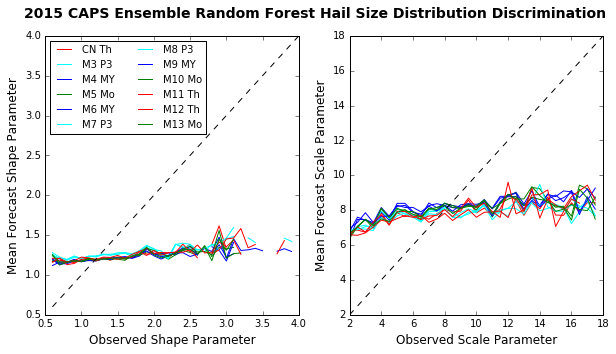

In [7]:
def mean_absolute_error(forecast, obs):
    return np.mean(np.abs(forecast - obs))

scale_bins = np.arange(2, 18.5, 0.5)
shape_bins = np.arange(0.6, 4.1, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
mp_colors = {"Thompson": "red",
         "Morrison": "green",
         "P3": "cyan",
         "MY": "blue"}
for member in members:
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    obs_mean_scale = np.zeros(scale_bins.size - 1)
    obs_mean_shape = np.zeros(shape_bins.size - 1)
    for b, sbin in enumerate(scale_bins[:-1]):
        obs_mean_scale[b] = matched_data.loc[(matched_data["Scale"] >= sbin) & 
                                             (matched_data["Scale"] < scale_bins[b+1]), "Random-Forest-CV_Scale"].mean()
    for b, sbin in enumerate(shape_bins[:-1]):
        obs_mean_shape[b] = matched_data.loc[(matched_data["Shape"] >= sbin) & 
                                             (matched_data["Shape"] < shape_bins[b+1]), "Random-Forest-CV_Shape"].mean()
    ax1.plot(shape_bins[:-1], obs_mean_shape, label=member.strip("wrf-s3").strip("_arw").upper() + " " +
             member_info.loc[member, "MicrophysicsTrue"][:2], color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]])
    ax2.plot(scale_bins[:-1], obs_mean_scale, label=member.strip("wrf-s3").strip("_arw").upper(),
            color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]])
ax1.legend(loc=0, fontsize=10, ncol=2)
ax1.plot(shape_bins, shape_bins, 'k--')
ax2.plot(scale_bins, scale_bins, 'k--')
ax1.set_ylabel("Mean Forecast Shape Parameter", fontsize=12)
ax1.set_xlabel("Observed Shape Parameter", fontsize=12)
ax2.set_ylabel("Mean Forecast Scale Parameter", fontsize=12)
ax2.set_xlabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("2015 CAPS Ensemble Random Forest Hail Size Distribution Discrimination", fontsize=14, fontweight="bold")
plt.savefig("caps_2015_random_forest_obs_rel.pdf", dpi=300, bbox_inches="tight")
plt.savefig("caps_2015_random_forest_obs_rel.png", dpi=300, bbox_inches="tight")

In [26]:
matched_data = combo_data.loc[combo_data["Hail_Size"] > 0]

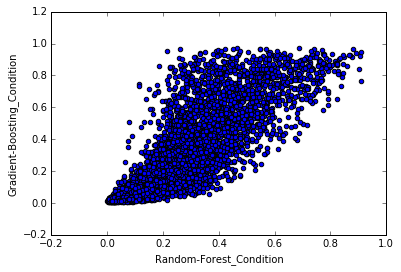

In [34]:
matched_data.plot(x="Random-Forest_Condition", y="Gradient-Boosting_Condition", kind="scatter")

In [76]:
for member in members:
    print member
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.1, hspace=0.05, wspace=0.05)
    h1 = ax1.hist2d(matched_data["Random-Forest-CV_Shape"], matched_data["Shape"], bins=np.arange(0, 4.05, 0.05), cmap="viridis",
              cmin=1)
    plt.colorbar(h1[3], ax=ax1)
    ax1.plot(np.arange(0, 6), np.arange(0,6), 'r--')
    ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 4)
    ax1.set_xlabel("Random Forest Shape Parameter", fontsize=12)
    ax1.set_ylabel("Observed Shape Parameter", fontsize=12)

    h2 = ax2.hist2d(matched_data["Random-Forest-CV_Scale"], matched_data["Scale"], bins=np.arange(0, 30.5, 0.5), 
               cmin=1,cmap="viridis")
    plt.colorbar(h2[3], ax=ax2)
    ax2.set_ylim(0, 20)
    ax2.set_xlim(0, 20)
    ax2.plot(np.arange(31), np.arange(31), 'r--')
    ax2.set_xlabel("Random Forest Scale Parameter", fontsize=12)
    ax2.set_ylabel("Observed Scale Parameter", fontsize=12)

    fig.suptitle("2015 CAPS {0} Random Forest Shape and Scale Histograms".format(member.strip("wrf-s3").strip("_arw").upper()), 
                 fontsize=14, fontweight="bold")
    plt.savefig("caps_2015_rf_shape_scale_hist_{0}.pdf".format(member.strip("wrf-s3").strip("_arw")))
    plt.close()

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [69]:
for member in members:
    print member
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.1, hspace=0.05)
    h1 = ax1.hist2d(matched_data["Elastic-Net_Shape"], matched_data["Shape"], bins=np.arange(0, 4.05, 0.05), cmap="viridis",
              cmin=1)
    plt.colorbar(h1[3], ax=ax1)
    ax1.plot(np.arange(0, 6), np.arange(0,6), 'r--')
    ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 4)
    ax1.set_xlabel("Elastic Net Shape Parameter", fontsize=12)
    ax1.set_ylabel("Observed Shape Parameter", fontsize=12)

    h2 = ax2.hist2d(matched_data["Elastic-Net_Scale"], matched_data["Scale"], bins=np.arange(0, 30.5, 0.5), 
               cmin=1,cmap="viridis")
    plt.colorbar(h2[3], ax=ax2)
    ax2.set_ylim(0, 30)
    ax2.set_xlim(0, 30)
    ax2.plot(np.arange(31), np.arange(31), 'r--')
    ax2.set_xlabel("Elastic Net Scale Parameter", fontsize=12)
    ax2.set_ylabel("Observed Scale Parameter", fontsize=12)

    fig.suptitle("2015 CAPS {0} Elastic Net Shape and Scale Histograms".format(member.strip("wrf-s3").strip("_arw").upper()), 
                 fontsize=14, fontweight="bold")
    plt.savefig("caps_2015_en_shape_scale_hist_{0}.pdf".format(member.strip("wrf-s3").strip("_arw")), bbox_inches="tight")
    plt.close()

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [77]:
for member in members:
    print member
    matched_data = combo_data[member].loc[combo_data[member]["Hail_Size"] > 0]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.1, hspace=0.05, wspace=0.05)
    h1 = ax1.hist2d(matched_data["Random-Forest-CV_Shape"], matched_data["Random-Forest-CV_Scale"], 
               bins=[np.arange(0,5,0.05), np.arange(0, 30, 0.5)],
               cmin=1, cmap="viridis")
    plt.colorbar(h1[3], ax=ax1)

    ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 20)
    ax1.set_xlabel("Random Forest Shape Parameter", fontsize=12)
    ax1.set_ylabel("Random Forest Scale Parameter", fontsize=12)
    h2 = ax2.hist2d(matched_data["Shape"], matched_data["Scale"],
               bins=[np.arange(0,5,0.05), np.arange(0, 30, 0.5)],
               cmin=1, cmap="viridis")
    plt.colorbar(h2[3], ax=ax2)

    ax2.set_ylim(0, 20)
    ax2.set_xlim(0, 4)
    ax2.set_xlabel("Observed Shape Parameter", fontsize=12)
    ax2.set_ylabel("Observed Scale Parameter", fontsize=12)
    fig.suptitle("2015 CAPS {0} Random Forest Joint Parameter Histograms".format(member.strip("wrf-s3").strip("_arw").upper()), fontsize=14, fontweight="bold")
    plt.savefig("caps_2015_rf_joint_hist_{0}.pdf".format(member.strip("wrf-s3").strip("_arw")))
    plt.close()

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


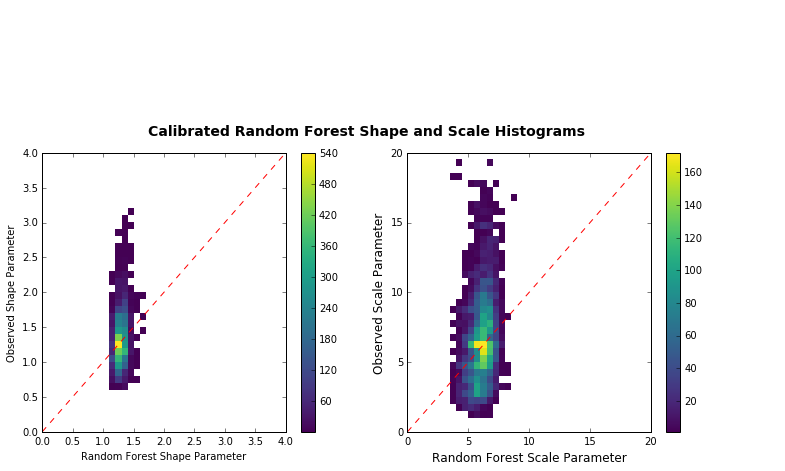

In [50]:
log_rf_shape = np.log(matched_data["Random-Forest-CV_Shape"])
log_shape = np.log(matched_data["Shape"])
log_rf_scale = np.log(matched_data["Random-Forest-CV_Scale"])
log_scale = np.log(matched_data["Scale"])
lr_shape = LinearRegression()
lr_shape.fit(log_rf_shape.reshape((log_rf_shape.shape[0], 1)), log_shape)
lr_scale = LinearRegression()
lr_scale.fit(log_rf_scale.reshape((log_rf_scale.shape[0], 1)), log_scale)
#plt.scatter(log_rf_shape, log_shape)
#plt.plot(np.arange(-1, 3), np.arange(-1, 3), 'k--')
#plt.hist2d(np.exp(lr.predict(log_rf_shape.reshape(log_rf_shape.size,1))),np.exp(log_shape), 
#           bins=np.arange(0, 30, 0.5), cmin=1, cmap="viridis")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
h1 = ax1.hist2d(np.exp(lr_shape.predict(log_rf_shape.reshape(log_rf_shape.size,1))), matched_data["Shape"], bins=np.arange(0, 5, 0.1), cmap="viridis",
          cmin=1)
ax1.plot(np.arange(0, 6), np.arange(0,6), 'r--')
plt.colorbar(h1[3], ax=ax1)
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 4)
ax1.set_xlabel("Random Forest Shape Parameter")
ax1.set_ylabel("Observed Shape Parameter")

h2 = ax2.hist2d(np.exp(lr_scale.predict(log_rf_scale.reshape(log_rf_scale.size,1))), matched_data["Scale"], 
           bins=np.arange(0, 31, 0.5), 
           cmin=1,cmap="viridis")
plt.colorbar(h2[3], ax=ax2)

ax2.set_ylim(0, 20)
ax2.set_xlim(0, 20)
ax2.plot(np.arange(31), np.arange(31), 'r--')
ax2.set_xlabel("Random Forest Scale Parameter", fontsize=12)
ax2.set_ylabel("Observed Scale Parameter", fontsize=12)
fig.suptitle("Calibrated Random Forest Shape and Scale Histograms", fontsize=14, fontweight="bold")
plt.savefig("rf_shape_scale_hist_cal.png", dpi=300, bbox_inches="tight")

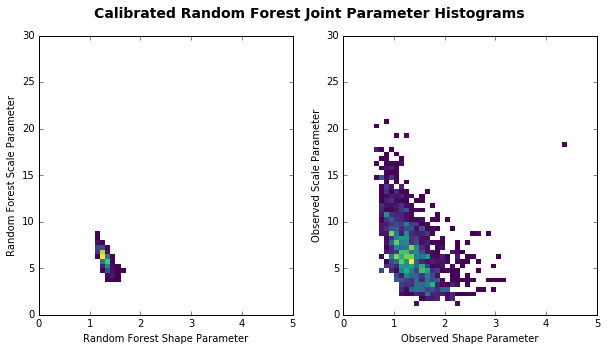

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.hist2d(np.exp(lr_shape.predict(log_rf_shape.reshape(log_rf_shape.size,1))), np.exp(lr_scale.predict(log_rf_scale.reshape(log_rf_scale.size,1))), 
           bins=[np.arange(0,5,0.1), np.arange(0, 30, 0.5)],
           cmin=1, cmap="viridis")
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 30)
ax1.set_xlabel("Random Forest Shape Parameter")
ax1.set_ylabel("Random Forest Scale Parameter")
ax2.hist2d(matched_data["Shape"], matched_data["Scale"],
           bins=[np.arange(0,5,0.1), np.arange(0, 30, 0.5)],
           cmin=1, cmap="viridis")
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 5)
ax2.set_xlabel("Observed Shape Parameter")
ax2.set_ylabel("Observed Scale Parameter")
fig.suptitle("Calibrated Random Forest Joint Parameter Histograms", fontsize=14, fontweight="bold")
plt.savefig("rf_joint_hist_cal.png", dpi=300, bbox_inches="tight")

In [9]:
rocs = {}
rels = {}
for member in members:
    rocs[member] = DistributedROC(thresholds=np.arange(0, 1.05, 0.05))
    rocs[member].update(combo_data[member]["Random-Forest_Condition"], 
                       np.where(combo_data[member]["Hail_Size"] > 0.5, 1, 0))
    rels[member] = DistributedReliability(thresholds=np.arange(0, 1.05, 0.05))
    rels[member].update(combo_data[member]["Random-Forest_Condition"].values, 
                       np.where(combo_data[member]["Hail_Size"] > 0.5, 1, 0))

wrf-s3cn_arw Thompson 0.723586924386
wrf-s3m3_arw P3 0.777244450086
wrf-s3m4_arw MY 0.782345627444
wrf-s3m5_arw Morrison 0.771373697863
wrf-s3m6_arw MY 0.781008791599
wrf-s3m7_arw P3 0.783996922038
wrf-s3m8_arw P3 0.784511763672
wrf-s3m9_arw MY 0.785086826123
wrf-s3m10_arw Morrison 0.777246320623
wrf-s3m11_arw Thompson 0.745559680391
wrf-s3m12_arw Thompson 0.733444622937
wrf-s3m13_arw Morrison 0.768860310651


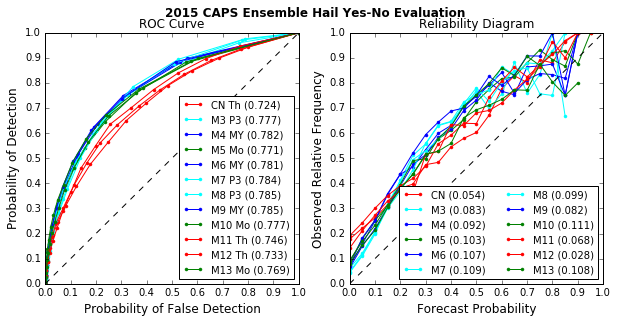

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4.5))
tick_vals = np.arange(0, 1.1, 0.1)
for member in members:
    rc = rocs[member].roc_curve()
    ax1.plot(rc["POFD"], rc["POD"], color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]],
            label=member.strip("wrf-s3").strip("_arw").upper() + " " + member_info.loc[member, "MicrophysicsTrue"][:2] + " ({0:0.3f})".format(rocs[member].auc()), marker='.')
    print member, member_info.loc[member, "MicrophysicsTrue"], rocs[member].auc()
    relc = rels[member].reliability_curve()
    ax2.plot(relc["Bin_Start"], relc["Positive_Relative_Freq"], color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]],
            label=member.strip("wrf-s3").strip("_arw").upper()  + " ({0:0.3f})".format(rels[member].brier_skill_score()), marker='.')
ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
ax1.set_xlabel("Probability of False Detection", fontsize=12)
ax1.set_ylabel("Probability of Detection", fontsize=12)
ax1.set_title("ROC Curve")
ax2.set_xlabel("Forecast Probability", fontsize=12)
ax2.set_ylabel("Observed Relative Frequency", fontsize=12)
ax2.set_title("Reliability Diagram")
ax1.set_xticks(tick_vals)
ax1.set_yticks(tick_vals)
ax2.set_xticks(tick_vals)
ax2.set_yticks(tick_vals)
fig.suptitle("2015 CAPS Ensemble Hail Yes-No Evaluation", fontsize=12, fontweight="bold")
ax1.legend(loc=0, fontsize=10, ncol=1)
ax2.legend(loc=0, fontsize=10, ncol=2)
plt.savefig("caps_2015_hail_roc_rel.png", dpi=300, bbox_inches="tight")
plt.savefig("caps_2015_hail_roc_rel.pdf", dpi=300, bbox_inches="tight")

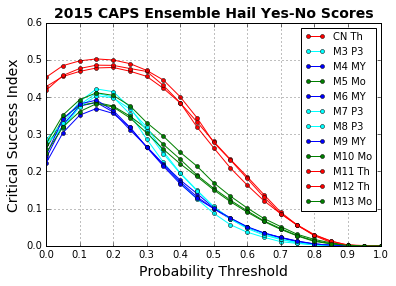

In [13]:
plt.figure(figsize=(6, 4))
hss_members = pd.DataFrame(index=rocs.values()[0].thresholds, columns=members, dtype=float)
for member in members:
    roc = rocs[member]
    hss_members.loc[:, member] = [x.csi() for x in roc.get_contingency_tables()]
    plt.plot(hss_members.index, hss_members[member], marker='o', color=mp_colors[member_info.loc[member, "MicrophysicsTrue"]],
             ms=4, 
             label=member.strip("wrf-s3").strip("_arw").upper() + " " + member_info.loc[member, "MicrophysicsTrue"][:2])
plt.xlabel("Probability Threshold", fontsize=14)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Critical Success Index", fontsize=14)
plt.legend(loc=0, fontsize=10)
plt.grid()
plt.title("2015 CAPS Ensemble Hail Yes-No Scores", fontsize=14, fontweight="bold")
plt.savefig("caps_2015_csi_curves.pdf", bbox_inches="tight")

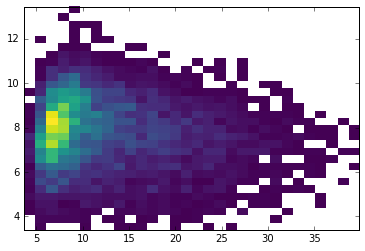

In [190]:
out = plt.hist2d(matched_data["cqgmax_mean"], 
                 matched_data["Random-Forest-CV_Scale"], 
                 bins=30, cmin=1, cmap="viridis")

In [80]:
combo_data[member].columns

Index([u'Step_ID', u'Track_ID', u'Date', u'Forecast_Hour', u'Valid_Hour_UTC',
       u'Duration', u'Centroid_Lon', u'Centroid_Lat', u'Storm_Motion_U',
       u'Storm_Motion_V',
       ...
       u'Gradient-Boosting_Condition', u'Random-Forest_Shape',
       u'Random-Forest_Location', u'Random-Forest_Scale', u'Elastic-Net_Shape',
       u'Elastic-Net_Location', u'Elastic-Net_Scale',
       u'Random-Forest-CV_Shape', u'Random-Forest-CV_Location',
       u'Random-Forest-CV_Scale'],
      dtype='object', length=295)